In [1]:
# Step-2:
#### 1. Image Contrast
#### 2. Data Split (Train(80), Validation(20))
#### 3. Transfer learning

In [10]:
import numpy as np
import tensorflow as tf
import keras
from imageContrast import img_cont
from skimage import exposure
from pylab import *
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from imageCropping import crop_img

In [2]:
trainingDataPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/TrainingDataset'

In [3]:
def imgContrastPreprocess(images, labels):
    equalized_images = tf.map_fn(lambda img: tf.py_function(img_cont, [img], Tout=tf.float32), images, fn_output_signature=tf.float32)
    return equalized_images, labels

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    trainingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='training'
)

Found 9625 files belonging to 2 classes.
Using 7700 files for training.


In [5]:
val_data = tf.keras.utils.image_dataset_from_directory(
    trainingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation'
)

Found 9625 files belonging to 2 classes.
Using 1925 files for validation.


In [6]:
trainDataset = train_data.map(imgContrastPreprocess).repeat()

In [7]:
validDataset = val_data.map(imgContrastPreprocess)

In [8]:
# Model Structure

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='auc')])
earlyStopping = EarlyStopping(monitor='val_auc', patience=5, verbose=1, mode='max')
checkPoint = ModelCheckpoint(
    'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel2.h5',
    monitor = 'val_auc',
    verbose = 1,
    save_best_only=True,
    mode='max'
)
history = model.fit(
    trainDataset,
    steps_per_epoch=floor(7700//32),
    epochs=100,
    validation_data=validDataset,
    validation_steps=floor(1925//32),
    callbacks=[earlyStopping,checkPoint]
)

loss, accuracy = model.evaluate(validDataset,steps=floor(1925//32))

Epoch 1/100
240/240 [==============================] - ETA: 0s - loss: 0.5864 - auc: 0.7534
Epoch 1: val_auc improved from -inf to 0.85870, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\fourLayerModel2.h5
240/240 [==============================] - 744s 3s/step - loss: 0.5864 - auc: 0.7534 - val_loss: 0.4623 - val_auc: 0.8587
Epoch 2/100
240/240 [==============================] - ETA: 0s - loss: 0.4004 - auc: 0.8923
Epoch 2: val_auc improved from 0.85870 to 0.91422, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\fourLayerModel2.h5
240/240 [==============================] - 783s 3s/step - loss: 0.4004 - auc: 0.8923 - val_loss: 0.3818 - val_auc: 0.9142
Epoch 3/100
240/240 [==============================] - ETA: 0s - loss: 0.3350 - auc: 0.9250
Epoch 3: val_auc improved from 0.91422 to 0.92615, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\fourLayerModel2.h5
240/240 [===========================

In [14]:
best_epochLocation = history.history['val_auc'].index(max(history.history['val_auc']))
best_epochLocation

4

In [15]:
best_history = {key: values[:best_epochLocation + 1] for key, values in history.history.items()}
best_history

{'loss': [0.5864409804344177,
  0.40037107467651367,
  0.3350182771682739,
  0.2946625053882599,
  0.23457393050193787],
 'auc': [0.7534264326095581,
  0.8923483490943909,
  0.9250267148017883,
  0.9428640007972717,
  0.9636356234550476],
 'val_loss': [0.46225690841674805,
  0.3817703127861023,
  0.3961431682109833,
  0.35027244687080383,
  0.2972026467323303],
 'val_auc': [0.8587014675140381,
  0.9142175316810608,
  0.9261492490768433,
  0.9357627034187317,
  0.9472262263298035]}

In [15]:
model.save('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel.h5')

In [12]:
savedModel = tf.keras.models.load_model('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel2.h5')

In [19]:
acc = best_history['auc']
loss = best_history['loss']
val_acc = best_history['val_auc']
val_loss = best_history['val_loss']

In [22]:
epoch = range(1, len(acc)+1)

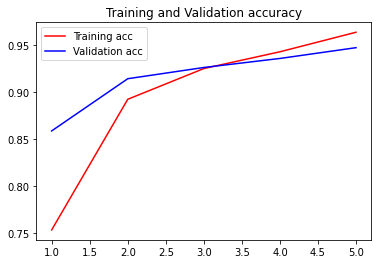

In [23]:
plt.plot(epoch, acc, 'r', label = 'Training acc')
plt.plot(epoch, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

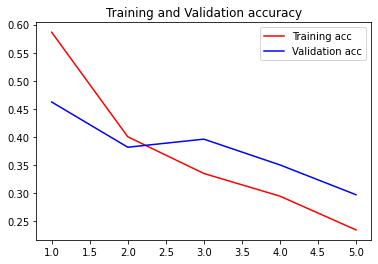

In [24]:
plt.plot(epoch, loss, 'r', label = 'Training acc')
plt.plot(epoch, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

In [21]:
# Test Data

In [25]:
testingDataPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2'

In [26]:
test_data = tf.keras.utils.image_dataset_from_directory(
    testingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32
)

Found 3553 files belonging to 2 classes.


In [27]:
#crop Data

In [28]:
def imgCropPreprocess(images,labels):
    cropped_images = tf.map_fn(lambda img: tf.py_function(crop_img, [img], Tout=tf.float32), images)
    return cropped_images,labels

In [29]:
testCropped_data = test_data.map(imgCropPreprocess)

In [30]:
a = testCropped_data.as_numpy_iterator()

In [31]:
img, label = a.next()

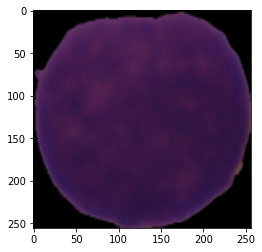

In [32]:
imshow(img[0])

In [33]:
testCont_data = testCropped_data.map(imgContrastPreprocess)

In [34]:
saved_model = tf.keras.models.load_model('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel2.h5')

In [35]:
# prediction

In [36]:
y_predict = saved_model.predict(testCont_data)

112/112 [==============================] - 226s 2s/step


In [37]:
y_predict_binary = (y_predict>0.5).astype(int)

In [38]:
y_pred = np.round(y_predict).flatten()

In [39]:
y_predict_binary

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [40]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [41]:
y_true = np.concatenate([y for x, y in testCont_data], axis=0)

In [42]:
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)
f1Score = f1_score(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1_score: {f1Score:.4f}')

Precision: 0.7538
Recall: 0.0199
f1_score: 0.0389


In [43]:
confusionMatrix = confusion_matrix(y_true, y_predict_binary)
print(confusionMatrix)

[[1080   16]
 [2408   49]]


In [44]:
layer_names = [layer.name for layer in saved_model.layers if 'conv' in layer.name]
visualize_model = Model(inputs=saved_model.inputs, outputs=[saved_model.get_layer(name).output for name in layer_names])

In [45]:
a = testCont_data.as_numpy_iterator()

In [46]:
img1, label1 = a.next()

In [47]:
img10,label10 = img1[0],label1[0]

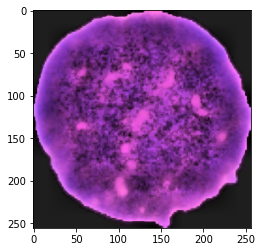

In [48]:
imshow(img10)

In [49]:
label10

1

In [50]:
img10 = np.expand_dims(img10,axis=0)

In [54]:
(saved_model.predict(img10)>0.5).astype(int)

1/1 [==============================] - 0s 65ms/step


array([[0]])

In [51]:
activations = visualize_model(img10)

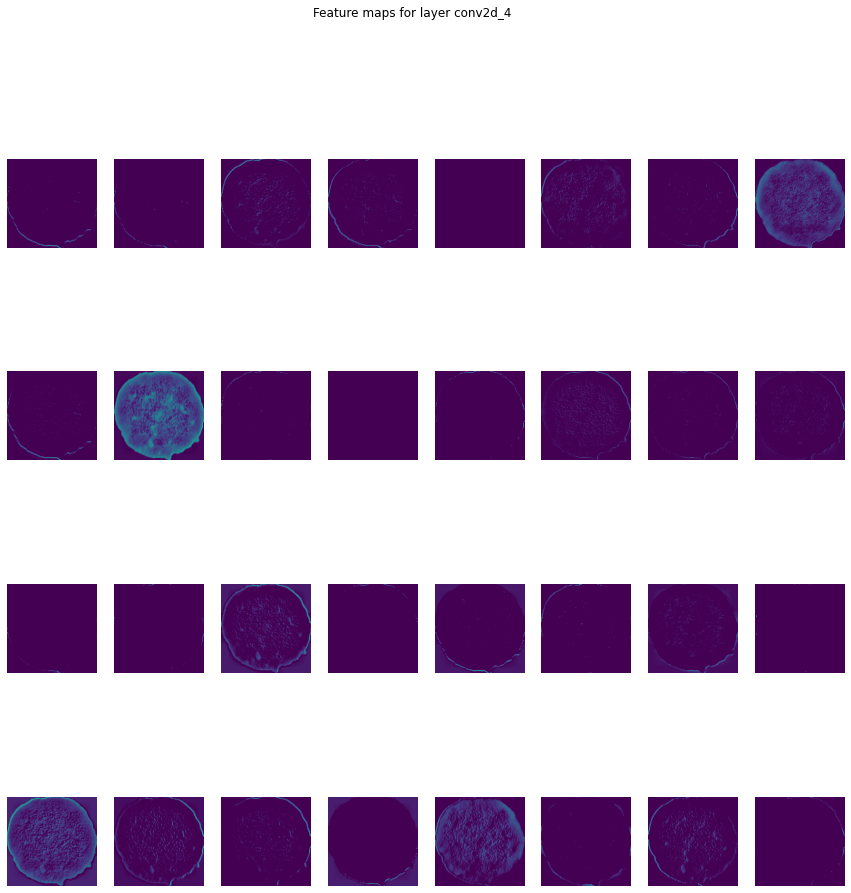

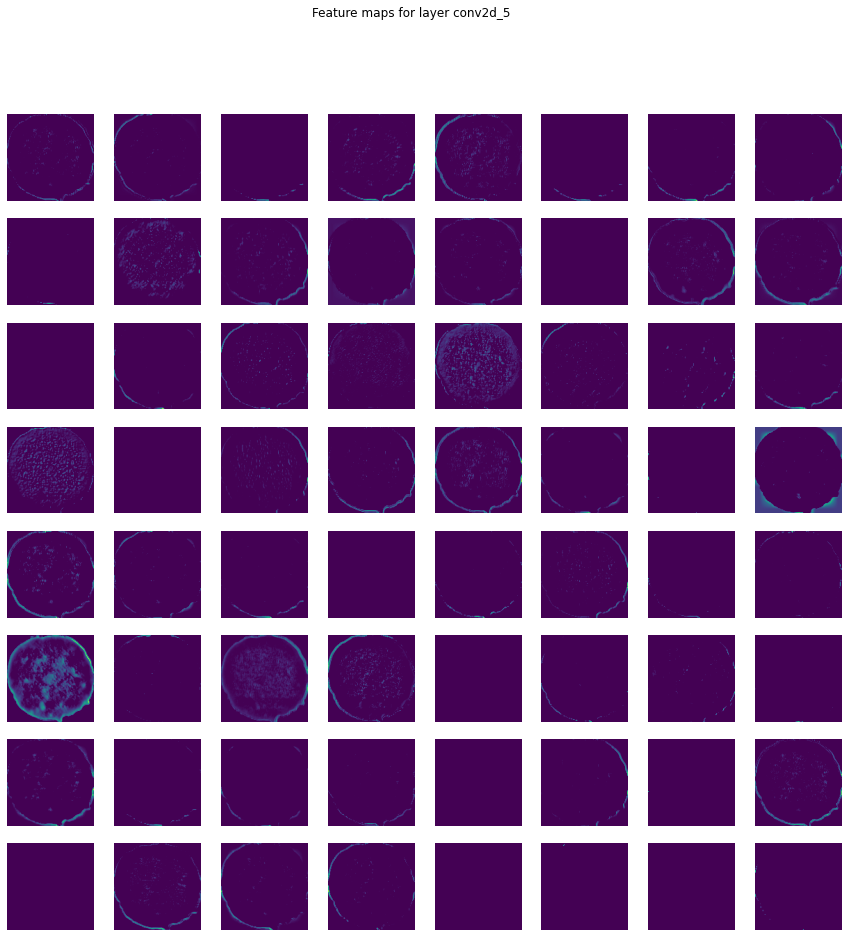

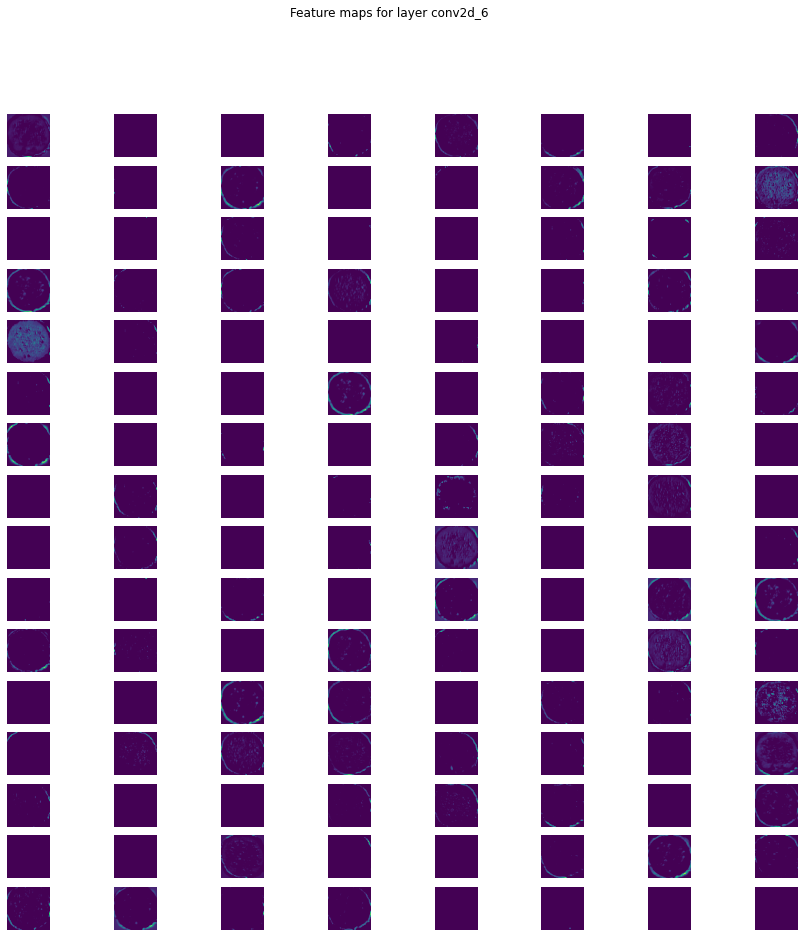

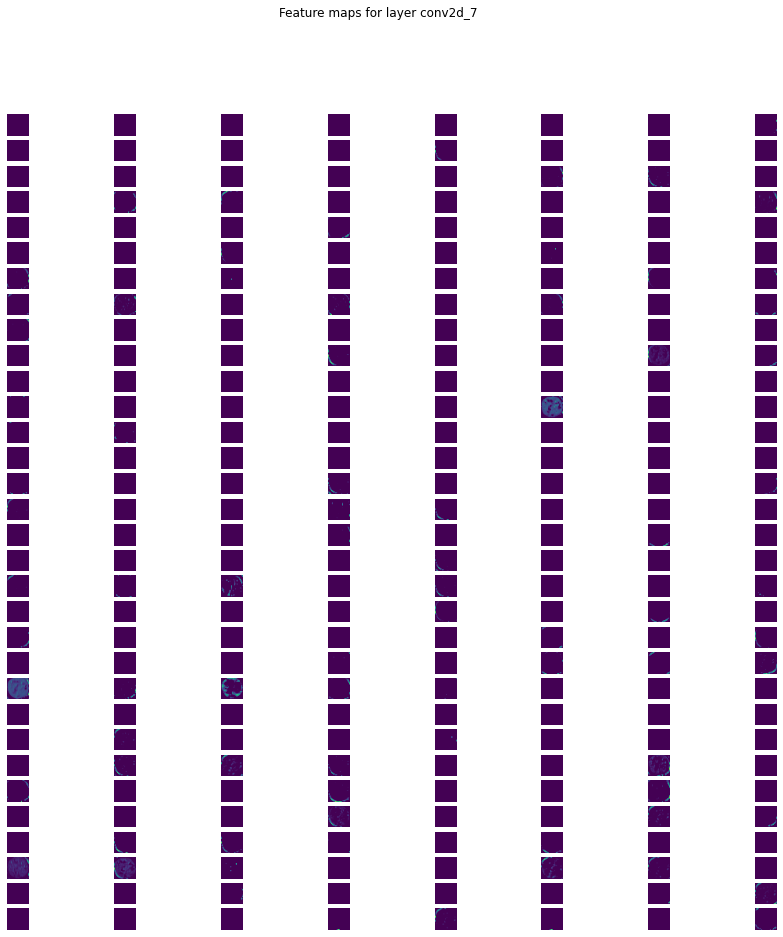

In [52]:
def display_feature_maps(activations, layer_names):
    for i, activation in enumerate(activations):
        layer_name = layer_names[i]
        num_filters = activation.shape[-1]

        # Calculate the number of rows and columns for the grid
        no_cols = 8
        grid_rows = num_filters // no_cols

        fig, axes = plt.subplots(grid_rows, no_cols, figsize=(15, 15))
        fig.suptitle(f"Feature maps for layer {layer_name}")

        for j in range(num_filters):
            ax = axes[j // no_cols, j % no_cols]
            ax.imshow(activation[0, :, :, j], cmap='viridis')
            ax.axis('off')

        plt.show()

# Call the function with the activations and layer names
display_feature_maps(activations, layer_names)